# Demand Curve Fitting

There are many ways to model the demand curve. In general, you want a function that models the decrease of demand/quantity as price increase. Three common (but not exhaustive) ways to model a demand curve could be as follows.

- $q = \beta_0 + \beta_1 p$, linear
- $q = e^{\beta_0 + \beta_1 ln p}$, exponential
- $q = \dfrac{C}{1 + e^{\alpha (p - p_0)}}$, sigmoidal

If we are given some empirical demand curve data, let's see how we can fit the data to these models.

## Data

The data is simulated as follows for the linear $q_L$, exponential $q_E$ and sigmoidal $q_S$ models.

- $q_L = 100 - p + \epsilon$
- $q_E = e^{4.5 - 0.5 \ln p} + \epsilon$
- $q_S = \dfrac{100}{1 + e^{0.2 (p - 50)}} + \epsilon$

In [1]:
import pandas as pd
import numpy as np
import random

def lin(p, b_0, b_1):
    e = np.random.normal(10, 5, p.shape[0])
    return b_0 + b_1 * p + e

def exp(p, b_0, b_1):
    e = np.random.normal(10, 5, p.shape[0])
    return np.exp(b_0 + b_1 * np.log(p)) + e

def sig(p, C, alpha, p_0):
    e = np.random.normal(10, 5, p.shape[0])
    return (C / (1 + np.exp(alpha * (p - p_0)))) + e

random.seed(37)
np.random.seed(37)

df = pd.DataFrame({
        'p': np.arange(1, 101, 1)
    }) \
    .assign(
        q_lin=lambda d: lin(d['p'], 100, -1.0),
        q_exp=lambda d: exp(d['p'], 4.5, -1.0),
        q_sig=lambda d: sig(d['p'], 100, 0.2, 50) 
    )
df.shape

(100, 4)

## Visualize simulated data

We have added some noise to the simulated data to emulate real world data.

<Axes: title={'center': 'Simulated data'}, xlabel='p', ylabel='quantity'>

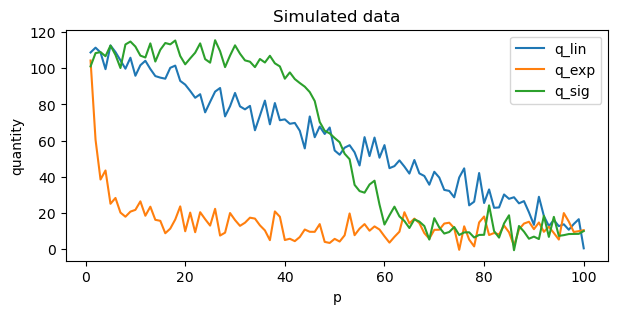

In [2]:
df \
    .set_index(['p'])[['q_lin', 'q_exp', 'q_sig']] \
    .plot(kind='line', figsize=(7, 3), title='Simulated data', ylabel='quantity')

## Curve fitting

Curve fitting is relatively easy to do. Below, we find the optimal parameters for all three models. You can see that the true and fitted parameters are pretty close. 

In [3]:
def lin_decay(p, b_0, b_1):
    return b_0 + b_1 * p

def exp_decay(p, b_0, b_1):
    return np.exp(b_0 + b_1 * np.log(p))

def sig_decay(p, C, alpha, p_0):
    return (C / (1 + np.exp(alpha * (p - p_0))))

In [4]:
from scipy.optimize import curve_fit

x = df['p']
y = df['q_lin']
p_hat = [y.mean(), x.mean()]
lin_opt, _ = curve_fit(lin_decay, x, y, p_hat, method='dogbox', maxfev=1_000)

pd.DataFrame([[100, -1], [lin_opt[0], lin_opt[1]]], columns=[r'$b_0$', r'$b_1$'], index=['true', 'fitted'])

,$b_0$,$b_1$
true,100.000000,-1.0000
fitted,110.980499,-1.0134


In [5]:
x = df['p']
y = df['q_exp']
p_hat = [y.mean(), -0.5]
exp_opt, _ = curve_fit(exp_decay, x, y, p_hat, method='dogbox', maxfev=1_000)

pd.DataFrame([[4.5, -1], [exp_opt[0], exp_opt[1]]], columns=[r'$b_0$', r'$b_1$'], index=['true', 'fitted'])

,$b_0$,$b_1$
true,4.500000,-1.000000
fitted,4.503159,-0.562201


In [6]:
x = df['p']
y = df['q_sig']
p_hat = [x.max(), 1.0, x.mean()]
sig_opt, _ = curve_fit(sig_decay, x, y, p_hat, method='dogbox', maxfev=1_000)

pd.DataFrame([[100, 0.2, 50], [sig_opt[0], sig_opt[1], sig_opt[2]]], columns=[r'$C$', r'$\alpha$', r'$p_0$'], index=['true', 'fitted'])

,$C$,$\alpha$,$p_0$
true,100.000000,0.200000,50.000000
fitted,110.462129,0.148341,51.830587


## Errors

Let's compute the errors of the fitted mode. We'll look at Mean Absolute Error `MAE`, Mean Absolute Percentage Error `MAPE` and Weighted Absolute Percentage Error `WAPE`.

- $\mathrm{MAE} = \dfrac{1}{n} \sum \left| q_{i}^{t} - q_{i}^{p} \right|$
- $\mathrm{MAPE} = \dfrac{1}{n} \sum \left| \dfrac{q_{i}^{t} - q_{i}^{p}}{q_i^t} \right|$
- $\mathrm{WAPE} = \dfrac{1}{n} \dfrac{\sum \left| q_{i}^{t} - q_{i}^{p} \right|}{\sum \left| q_i^t \right|} $

In [7]:
pred_df = df \
    .assign(
        y_lin=lambda d: lin_decay(d['p'], lin_opt[0], lin_opt[1]),
        y_exp=lambda d: exp_decay(d['p'], exp_opt[0], exp_opt[1]),
        y_sig=lambda d: sig_decay(d['p'], sig_opt[0], sig_opt[1], sig_opt[2]),
        tr_lin=lambda d: d['p'] * d['y_lin'],
        tr_exp=lambda d: d['p'] * d['y_exp'],
        tr_sig=lambda d: d['p'] * d['y_sig'],
        pr_lin=lambda d: (d['p'] - 50) * d['y_lin'],
        pr_exp=lambda d: (d['p'] - 50) * d['y_exp'],
        pr_sig=lambda d: (d['p'] - 50) * d['y_sig'],
        lin_mae=lambda d: np.abs(d['q_lin'] - d['y_lin']),
        exp_mae=lambda d: np.abs(d['q_exp'] - d['y_exp']),
        sig_mae=lambda d: np.abs(d['q_sig'] - d['y_sig']),
        lin_mape=lambda d: np.abs(d['q_lin'] - d['y_lin']) / d['q_lin'],
        exp_mape=lambda d: np.abs(d['q_exp'] - d['y_exp']) / d['q_exp'],
        sig_mape=lambda d: np.abs(d['q_sig'] - d['y_sig']) / d['q_sig'],
        lin_wape=lambda d: np.abs(d['q_lin'] - d['y_lin']) / d['q_lin'].sum(),
        exp_wape=lambda d: np.abs(d['q_exp'] - d['y_exp']) / d['q_exp'].sum(),
        sig_wape=lambda d: np.abs(d['q_sig'] - d['y_sig']) / d['q_sig'].sum()
    )

pred_df \
    [['lin_mae', 'exp_mae', 'sig_mae', 
      'lin_mape', 'exp_mape', 'sig_mape', 
      'lin_wape', 'exp_wape', 'sig_wape']] \
    .mean()

lin_mae     4.084114
exp_mae     4.746720
sig_mae     5.422417
lin_mape    0.250673
exp_mape    0.144898
sig_mape    0.284749
lin_wape    0.000683
exp_wape    0.003253
sig_wape    0.000916
dtype: float64

## Visualize raw and fitted curve fits

Let's see visually see how good was our fitted model to the data.

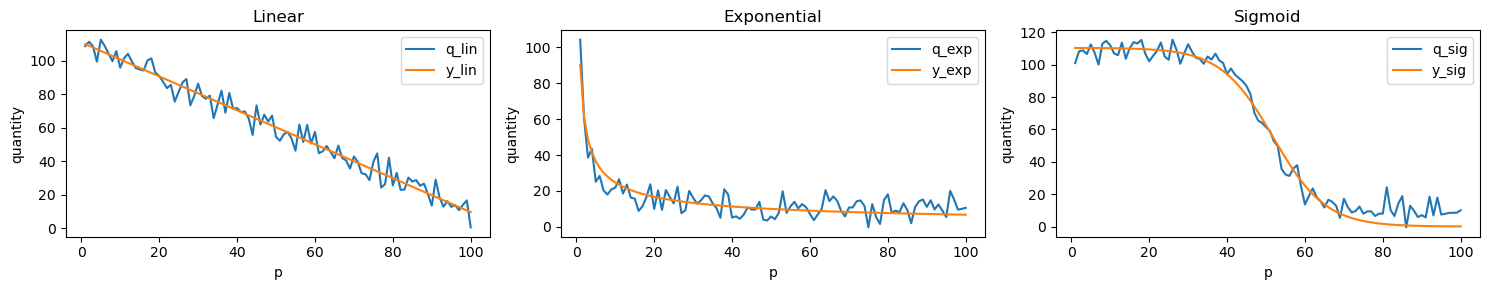

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 3))

for _title, _suffix, _ax in zip(['Linear', 'Exponential', 'Sigmoid'], ['lin', 'exp', 'sig'], np.ravel(ax)):
    pred_df \
        .set_index(['p']) \
        [[f'q_{_suffix}', f'y_{_suffix}']] \
        .plot(kind='line', ax=_ax, title=_title, ylabel='quantity')

fig.tight_layout()

## Visualize revenue and profit

We can visualize the total revenue `tr` or $r$ and profit `pr` or $t$ curves of each of these fitted models. The formulas are

- $r = qp$, and
- $t = q(p - c)$, 

where

- $q$ is quantity/demand,
- $p$ is unit price, and
- $c$ is unit cost.

These curves are important for revenue and profit maximization; the point on these curves whose tangent line has a slope of zero maximizes revenue or profit. Clearly, you can see that the exponential model is unbounded (revenue and profit seems to monotically increase!). The linear and sigmoidal models are more reasonable as they have a price associated with a globally maximal revenue and profit. Additionally, you can see that maximizing total revenue and profit are not necessarily the same thing. 

For the linear model, the optimal price for

- maximizing revenue is 55, and
- maximizing profit is 80.

For the sigmoidal model, the optimal price for

- maximizing revenue is 41, and
- maximizing profit is 59.

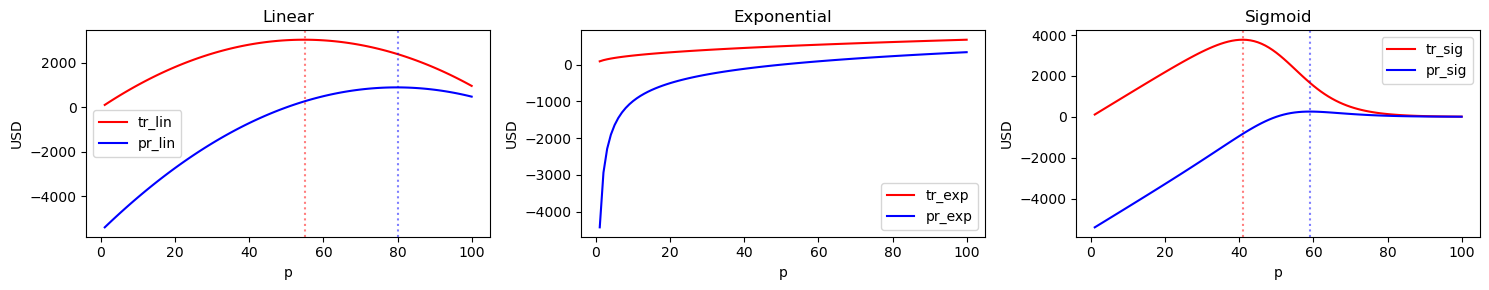

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

for _title, _suffix, _ax in zip(['Linear', 'Exponential', 'Sigmoid'], ['lin', 'exp', 'sig'], np.ravel(ax)):
    pred_df \
        .set_index(['p'])[[f'tr_{_suffix}', f'pr_{_suffix}']] \
        .plot(kind='line', ax=_ax, title=_title, ylabel='USD', color=['r', 'b'])
    
    if _suffix == 'lin':
        p_tr = pred_df.sort_values(['tr_lin'], ascending=False).iloc[0]['p']
        p_pr = pred_df.sort_values(['pr_lin'], ascending=False).iloc[0]['p']
    elif _suffix == 'sig':
        p_tr = pred_df.sort_values(['tr_sig'], ascending=False).iloc[0]['p']
        p_pr = pred_df.sort_values(['pr_sig'], ascending=False).iloc[0]['p']
    else:
        p_tr, p_pr = None, None
        
    if p_tr is not None and p_pr is not None:
        _ax.axvline(x=p_tr, alpha=0.5, linestyle='dotted', color='red')
        _ax.axvline(x=p_pr, alpha=0.5, linestyle='dotted', color='blue')

fig.tight_layout()

## Point elasticity

Another way to find the price that will yield the highest revenue is to find the price whose point elasticity is unitary. To compute the point elasticities for all the points on a demand curve, we use the following formula

- $E_d = \dfrac{\mathrm{d} q}{\mathrm{d} p} \dfrac{p}{q}$

where

- $\dfrac{\mathrm{d} q}{\mathrm{d} p}$ is the slope of the tangent line at the $(p, q)$ point on the demand curve.

For the linear and sigmoidal demand curves, $E_d$ changes at every $(p, q)$ point. For the exponential demand curve, $E_d$ stays constant; sometimes, a demand curve modeled using exponential decay is called the `constant elasticity` model, thus.

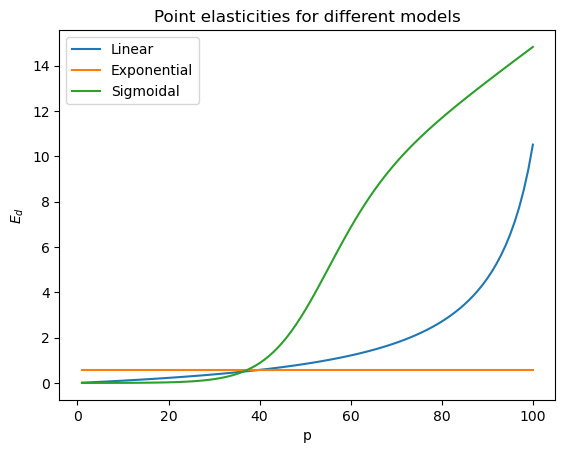

In [10]:
import numdifftools as nd

ped_df = pred_df[['p', 'y_lin', 'y_exp', 'y_sig']] \
    .assign(
        dqdp_lin=lambda d: np.diag(nd.Gradient(lambda p: lin_decay(p, b_0=lin_opt[0], b_1=lin_opt[1]))(d['p'])),
        dqdp_exp=lambda d: np.diag(nd.Gradient(lambda p: exp_decay(p, b_0=exp_opt[0], b_1=exp_opt[1]))(d['p'])),
        dqdp_sig=lambda d: np.diag(nd.Gradient(lambda p: sig_decay(p, C=sig_opt[0], alpha=sig_opt[1], p_0=sig_opt[2]))(d['p'])),
        ped_lin=lambda d: np.abs(d['dqdp_lin'] * d['p'] / d['y_lin']),
        ped_exp=lambda d: np.abs(d['dqdp_exp'] * d['p'] / d['y_exp']),
        ped_sig=lambda d: np.abs(d['dqdp_sig'] * d['p'] / d['y_sig']),
        diff_lin=lambda d: np.abs(d['ped_lin'] - 1),
        diff_exp=lambda d: np.abs(d['ped_exp'] - 1),
        diff_sig=lambda d: np.abs(d['ped_sig'] - 1)
    )

_ = ped_df \
    .set_index(['p']) \
    [['ped_lin', 'ped_exp', 'ped_sig']] \
    .rename(columns={
        'ped_lin': 'Linear',
        'ped_exp': 'Exponential',
        'ped_sig': 'Sigmoidal'
    }) \
    .plot(kind='line', ylabel=r'$E_d$', title=r'Point elasticities for different models')

If we find the price whose point elasticity is (nearly) equal to 1, $E_d = 1$, we get 55 for the linear model and 41 for the sigmoidal model. These results matches the approach of finding the highest point on the revenue curve and looking at the corresponding price to determine the optimal price to maximize revenue.

In [11]:
ped_df.sort_values(['diff_lin']).iloc[0]['p'], ped_df.sort_values(['diff_sig']).iloc[0]['p']

(55.0, 41.0)